In [25]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import math

import gensim
from gensim import corpora
from pprint import pprint


# data import

In [13]:
raw_off_df = pd.read_csv("/Users/thibaultrolland/Projects/arcom/data/en.openfoodfacts.org.products.csv", sep='\t')

/var/folders/cf/xcc222mj0yg3dzy7mljbx99w0000gn/T/ipykernel_72466/3360868185.py:1: DtypeWarning: Columns (0,9,15,21,22,23,29,30,31,32,33,42,44,50,54,65,70,148) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_off_df = pd.read_csv("/Users/thibaultrolland/Projects/arcom/data/en.openfoodfacts.org.products.csv", sep='\t')


In [14]:
raw_arcom_df = pd.read_csv("/Users/thibaultrolland/Projects/arcom/data/ARCOM.csv")

/var/folders/cf/xcc222mj0yg3dzy7mljbx99w0000gn/T/ipykernel_72466/1379898180.py:1: DtypeWarning: Columns (37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_arcom_df = pd.read_csv("/Users/thibaultrolland/Projects/arcom/data/ARCOM.csv")


In [16]:
with open('data/cross_arcom_off/index_per_brand.json', 'r') as file:
    index_per_brand = json.load(file)

# product data

## Rolling mean

In [92]:
product_names = []
brands = []
off_index = []
ecoscore = []
nutriscore = []
arcom_index_list = []
for brand, value in index_per_brand.items():
    id_list = value['off_id']
    for id in id_list:
        row = raw_off_df.loc[id]
        product = row['product_name']
        product_names.append(product)
        brands.append(brand)
        nutriscore.append(row['nutriscore_grade'])
        ecoscore.append(row['ecoscore_grade'])
        off_index.append(id)

product_names_df = pd.DataFrame({
    'brand': brands, 
    'nutriscore': nutriscore,
    'ecoscore': ecoscore,
    'product': product_names, 
    'off_index': off_index})

In [93]:
# nutriscore analysis

In [94]:
score_list = ['a','b','c','d','e']

In [95]:
score_conversion_table = {'a': 5, 'b': 4, 'c': 3, 'd': 2, 'e': 1}
inv_score_conversion_table = { 5: 'a', 4: 'b', 3: 'c', 2: 'd', 1: 'e' }

nutri_prod_df = product_names_df[[x in score_list for x in product_names_df.nutriscore]]
nutri_prod_df['numeric_score'] = nutri_prod_df['nutriscore'].apply(lambda x: score_conversion_table[x])

/var/folders/cf/xcc222mj0yg3dzy7mljbx99w0000gn/T/ipykernel_72466/2214760266.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nutri_prod_df['numeric_score'] = nutri_prod_df['nutriscore'].apply(lambda x: score_conversion_table[x])


In [96]:
median_scores = nutri_prod_df.groupby('brand')['numeric_score'].agg(['mean', 'median', 'std'])
median_scores = median_scores.sort_values(by='mean')

In [97]:
median_scores

,mean,median,std
brand,,,
speculoos,1.000000,1.0,NaN
laboratoire gallia,1.000000,1.0,0.000000
sheba,1.000000,1.0,NaN
lindt creation,1.000000,1.0,0.000000
knoppers,1.000000,1.0,0.000000
...,...,...,...
matines,4.973684,5.0,0.162221
materne pom potes,5.000000,5.0,NaN
max havelaar,5.000000,5.0,NaN


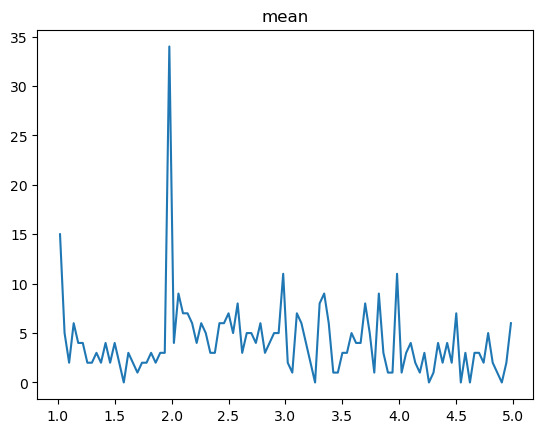

In [74]:
window_size = 100

def count_in_window(data, windows_count):
    count = []
    data_point = []
    w_size = (max(data) - min(data)) / windows_count
    boundaries = [min(data), min(data) + w_size]
    for i in range(windows_count):
        count.append(len([x for x in data if boundaries[0] <= x < boundaries[1]]))
        data_point.append((boundaries[1] + boundaries[0])/2)
        boundaries[0] += w_size
        boundaries[1] += w_size
    return data_point, count


means = list(median_scores['mean'])
X, y = count_in_window(means, window_size)

plt.plot(X,y)
plt.title('mean')
plt.show()


#median_count = median_scores['median'].value_counts()
#plt.bar(median_count.index, median_count)
#plt.title('median')
#plt.show()



## brands per category

In [135]:
from gensim import corpora
from gensim.models import LdaModel
from wordcloud import WordCloud
from itertools import chain
import ast

In [112]:
brand_score_df = median_scores
brand_score_df['arcom_indexes'] = [index_per_brand[index]['arcom_id'] for index in brand_score_df.index]
brand_score_df['median'] = brand_score_df['median'].apply(lambda x: math.floor(x))
brand_score_df

,mean,median,std,arcom_indexes
brand,,,,
speculoos,1.000000,1,NaN,"[22785, 11106, 6865, 28945, 12851, 10492, 10495]"
laboratoire gallia,1.000000,1,0.000000,"[44672, 35732, 6691, 39717, 2606, 2358, 7095, ..."
sheba,1.000000,1,NaN,"[8454, 12683, 40748, 24653, 29791]"
lindt creation,1.000000,1,0.000000,"[15874, 17867, 15852, 17869, 17870, 11247, 818..."
knoppers,1.000000,1,0.000000,"[50112, 50113, 50177, 50181, 50153, 45941, 50168]"
...,...,...,...,...
matines,4.973684,5,0.162221,"[5250, 10210, 550, 1799, 10215, 1776, 15442, 1..."
materne pom potes,5.000000,5,NaN,"[25889, 25912, 32449, 13124, 32454, 27368, 324..."
max havelaar,5.000000,5,NaN,"[44776, 45261, 44774]"


In [115]:
ad_ids_per_score = brand_score_df.groupby('median')['arcom_indexes'].apply(lambda x: list(chain.from_iterable(x)))

In [146]:
score_df = raw_arcom_df.loc[ad_ids_per_score[1], ['Script', 'clean_script']]
score_df = score_df[[isinstance(x, str) for x in score_df['clean_script']]]
score_df['clean_script'] = score_df['clean_script'].apply(lambda x: ast.literal_eval(x))
documents = score_df['clean_script'].tolist()
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(doc) for doc in documents]
lda_model = gensim.models.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)
topics = lda_model.print_topics()